# Distillation de connaissances dans un réseau de neurone

In [2]:
import itertools
import math
import time
import os
import torch
import torchinfo
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch import Tensor, optim
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
import detectors
import timm

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [47]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU - training will be slow!")

✓ Using Apple Silicon GPU (MPS)


# ResNet + CIFAR10

## Dataset : CIFAR10

Data preparation

In [43]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2023, 0.1994, 0.2010)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

Loading data

In [44]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform,
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
)

In [45]:
test_dataset[2020][0].shape

torch.Size([3, 32, 32])

### Data visualisation

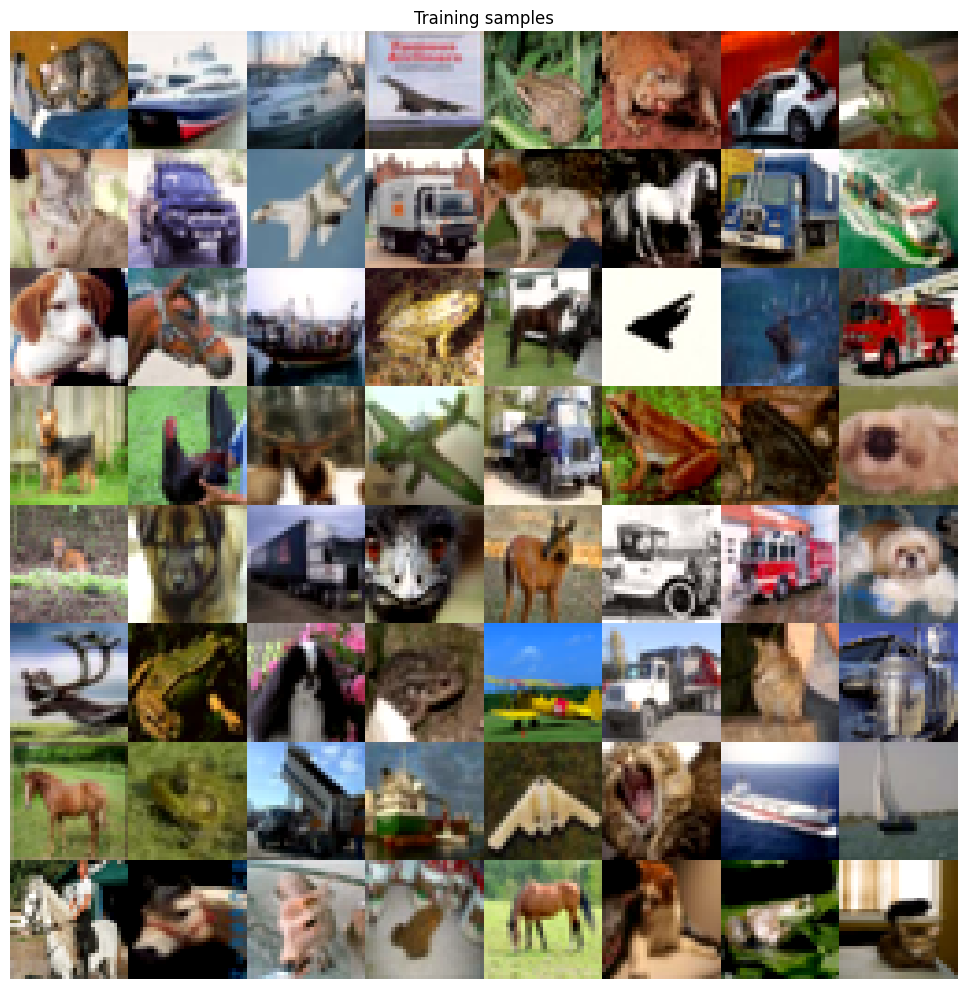

In [79]:
imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
imagenet_std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

def denormalize(img):
    img = img * imagenet_std + imagenet_mean
    img = np.clip(img, 0, 1)
    return img

grid_size = 8
img_size = 32

grid = np.zeros(
    (grid_size * img_size, grid_size * img_size, 3),
    dtype=np.float32
)

for i in range(grid_size):
    for j in range(grid_size):
        img, _ = test_dataset[i * grid_size + j]

        img = img.numpy()              # Tensor → numpy
        img = denormalize(img)         # Dé-normalisation
        img = img.transpose(1, 2, 0)   # (C,H,W) → (H,W,C)

        grid[
            i * img_size:(i + 1) * img_size,
            j * img_size:(j + 1) * img_size,
            :
        ] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
ax.set_title("Training samples")
ax.axis("off")
plt.tight_layout()
plt.show()

## The teacher : resnet18

In [127]:
teacher = timm.create_model("resnet18_cifar10", pretrained=True)
teacher.eval()
teacher.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_

Save teacher

In [9]:
torch.save(teacher.state_dict(), "trained_model/CIFAR10/teacher_CIFAR10.pth")

Loading saved teacher

In [71]:
teacher.load_state_dict(
    torch.load("trained_model/CIFAR10/teacher_CIFAR10.pth",
    map_location=device
))


<All keys matched successfully>

In [129]:
torchinfo.summary(teacher, input_size=(1, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─Identity: 1-4                          [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─Identity: 3-3                [1, 64, 32, 32]           --
│    │    └─ReLU: 3-4                    [1, 64, 32, 32]           --
│    │    └─Identity: 3-5                [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 64, 32, 32]           36,864
│ 

Test the teacher on the trainning sample.

In [57]:
def test_accuracy_CIFAR10(model):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad() :
    pbar = tqdm(
      test_loader,
      leave=True
    )

    for images, labels in pbar :
        images, labels = images.to(device), labels.to(device)
        logits = model(images)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            "accuracy": f"{correct/total*100:.2f}%"
        })
  return correct/total

100%|██████████| 157/157 [00:23<00:00,  6.82it/s, accuracy=94.98%]


In [73]:
teacher_accuracy = test_accuracy_CIFAR10(teacher)

100%|██████████| 157/157 [00:23<00:00,  6.81it/s, accuracy=94.98%]


## Student : A small convolution model

In [123]:
num_classes = 10

class SmallResCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
        )

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

In [126]:
student = SmallResCNN()
student.to(device)
torchinfo.summary(student, input_size=(1, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
SmallResCNN                              [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 8, 8]            --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           432
│    └─BatchNorm2d: 2-2                  [1, 16, 32, 32]           32
│    └─ReLU: 2-3                         [1, 16, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           4,608
│    └─BatchNorm2d: 2-5                  [1, 32, 32, 32]           64
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 64, 16, 16]           18,432
│    └─BatchNorm2d: 2-9                  [1, 64, 16, 16]           128
│    └─ReLU: 2-10                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-11                      [1, 128, 16, 16]          73,728
│ 

In [91]:
def distillation_loss(student_logits, teacher_logits, labels, T, alpha):
    loss_ce = F.cross_entropy(student_logits, labels)

    loss_kd = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction="batchmean"
    )

    return alpha * loss_ce + (1 - alpha) * (T * T) * loss_kd

In [115]:
def train_distillation(student, teacher, epochs, T, alpha):
    student.train()

    epochs = epochs
    accuracies_student = np.zeros(epochs)
    losses_student = np.zeros(epochs)

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{epochs} | alpha = {alpha}",
            leave=True
        )

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            student_logits = student(images)
            with torch.no_grad():
                teacher_logits = teacher(images)
            loss = distillation_loss(student_logits, teacher_logits, labels,T,alpha)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = student_logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "batch_loss": f"{loss.item():.4f}",
                "accuracy": f"{correct/total*100:.2f}%"
            })
        accuracies_student[epoch] = correct/total
        losses_student[epoch] = total_loss

        scheduler.step()
    return accuracies_student, losses_student

In [61]:
T = 4.0
alphas = [0.,0.1,0.3,0.5,0.7,0.9,1.]
epochs = 25

Witness fine-tuning | Epoch 1/1: 100%|██████████| 391/391 [01:23<00:00,  4.69it/s, batch_loss=8.3105, accuracy=42.84%] 
Witness fine-tuning | Epoch 1/1: 100%|██████████| 391/391 [01:13<00:00,  5.33it/s, batch_loss=6.6458, accuracy=41.72%]
Witness fine-tuning | Epoch 1/1: 100%|██████████| 391/391 [01:15<00:00,  5.20it/s, batch_loss=5.8368, accuracy=42.72%]
Witness fine-tuning | Epoch 1/1: 100%|██████████| 391/391 [01:17<00:00,  5.06it/s, batch_loss=3.9441, accuracy=42.57%]
Witness fine-tuning | Epoch 1/1: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s, batch_loss=3.0651, accuracy=41.57%]
Witness fine-tuning | Epoch 1/1: 100%|██████████| 391/391 [01:13<00:00,  5.30it/s, batch_loss=1.2859, accuracy=40.38%]


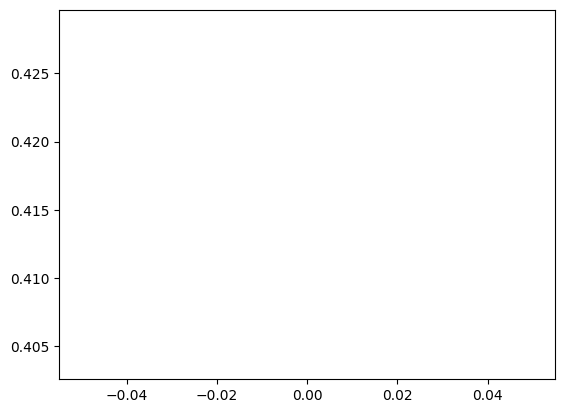

In [43]:
training_curves_CIFAR10 = np.zeros((2,len(alphas),epochs))

for i,alpha in enumerate(alphas) :
    student = SmallResCNN()
    student.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        student.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=5e-4
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=200
    )

    training_curves_CIFAR10[0,i], training_curves_CIFAR10[1,i] = train_distillation(student,teacher,epochs,T,alpha)
    torch.save(student.state_dict(), f"trained_model/CIFAR10/student_CIFAR10_{T}_{alpha}_{epochs}.pth")

In [6]:
np.save("training_logs/training_curves_CIFAR10.npy",training_curves_CIFAR10)

NameError: name 'training_curves_CIFAR10' is not defined

In [7]:
training_curves_CIFAR10 = np.load("training_logs/training_curves_CIFAR10.npy")

<function matplotlib.pyplot.show(close=None, block=None)>

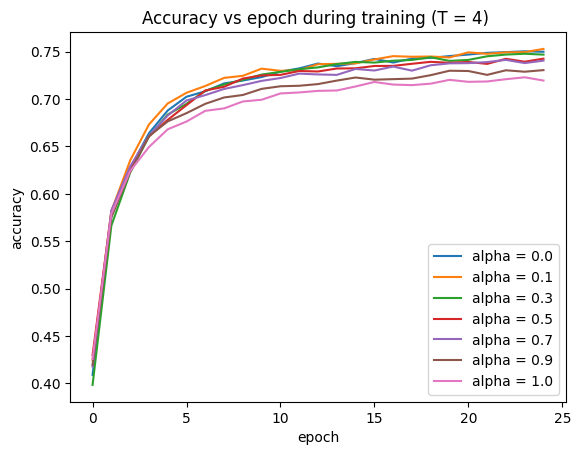

In [69]:
for i in range(len(alphas)):
  plt.plot(training_curves_CIFAR10[0,i,:],label=f"alpha = {alphas[i]}")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs epoch during training (T = 4) ")
plt.show

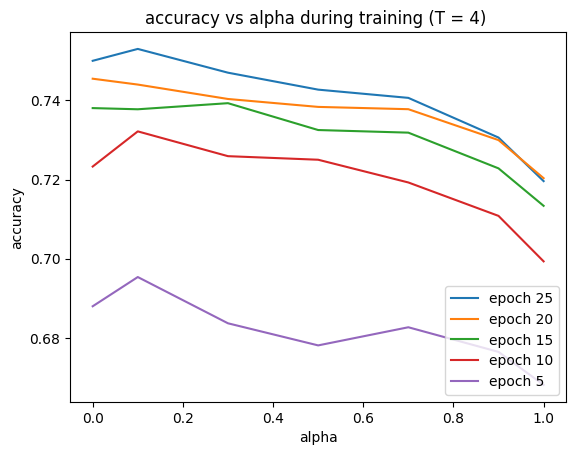

In [68]:
for i in range(0,epochs,5):
    plt.plot(alphas,training_curves_CIFAR10[0,:,epochs-i-1],label=f"epoch {epochs-i}")
plt.legend(loc="lower right")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("accuracy vs alpha during training (T = 4) ")
plt.show()

In [64]:
accruacies_test_data = np.zeros(len(alphas))

for i,alpha in enumerate(alphas) :
    trained_student = SmallResCNN()
    trained_student.load_state_dict(torch.load(
        f"trained_model/CIFAR10/student_CIFAR10_{T}_{alpha}_{epochs}.pth",
        map_location=device
        ))
    trained_student.to(device)
    accruacies_test_data[i] = test_accuracy_CIFAR10(trained_student)

100%|██████████| 157/157 [00:15<00:00, 10.37it/s, accuracy=63.67%] 


/var/folders/hf/cz9pm8_16vs_zz16xs5lw1xc0000gn/T/ipykernel_1549/1285540628.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


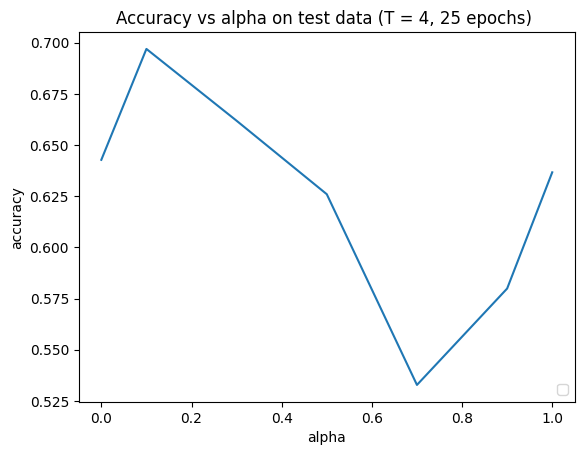

In [67]:
plt.plot(alphas,accruacies_test_data)
plt.legend(loc="lower right")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha on test data (T = 4, 25 epochs) ")
plt.show()

# CIFAR100

## Load dataset

In [74]:
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std  = (0.2675, 0.2565, 0.2761)

train_transform_100 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

test_transform_100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std),
])

In [76]:
train_dataset_100 = torchvision.datasets.CIFAR100(
    root="./data",
    train=True,
    download=True,
    transform=train_transform_100,
)

test_dataset_100 = torchvision.datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=test_transform_100,
)

train_loader_100 = DataLoader(
    train_dataset_100,
    batch_size=64,
    shuffle=True,
    num_workers=2,
)

test_loader_100 = DataLoader(
    test_dataset_100,
    batch_size=64,
    shuffle=False,
    num_workers=2,
)

100%|██████████| 169M/169M [30:28<00:00, 92.4kB/s]   


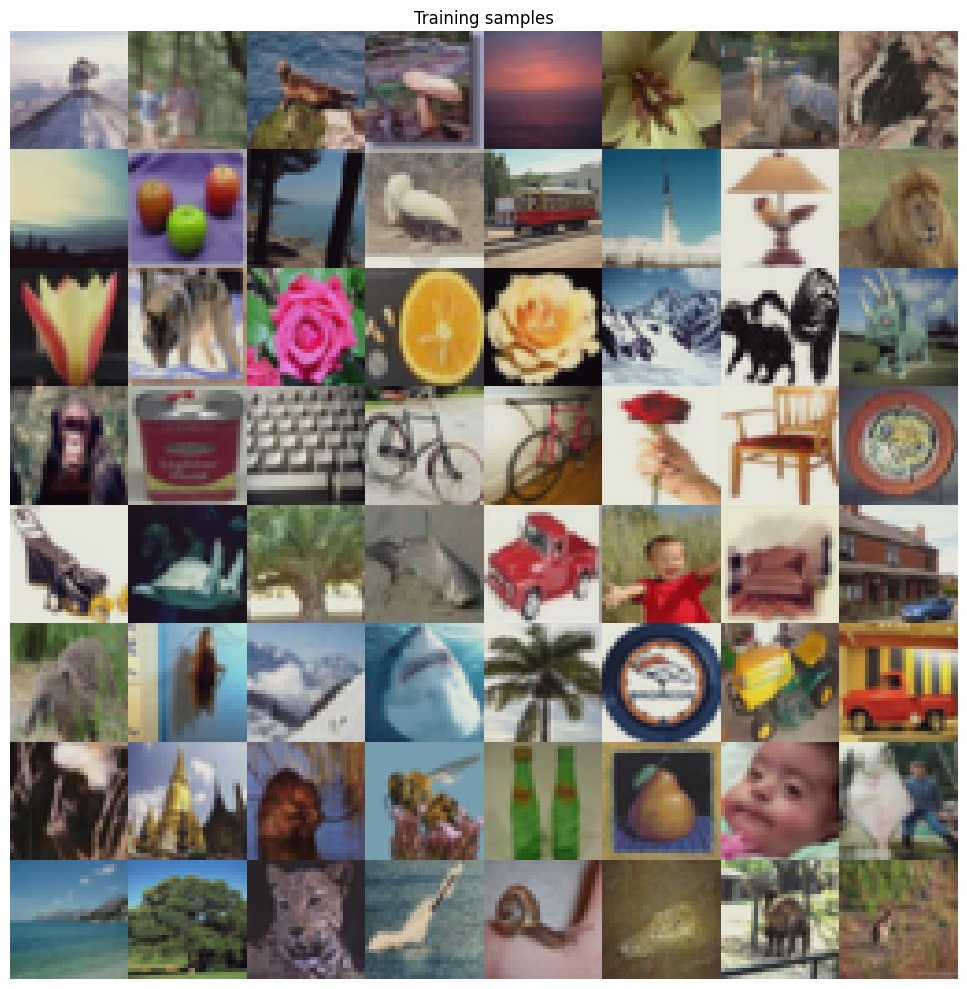

In [80]:
imagenet_mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
imagenet_std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

grid_size = 8
img_size = 32

for i in range(grid_size):
    for j in range(grid_size):
        img, _ = test_dataset_100[i * grid_size + j]

        img = img.numpy()              # Tensor → numpy
        img = denormalize(img)         # Dé-normalisation
        img = img.transpose(1, 2, 0)   # (C,H,W) → (H,W,C)

        grid[
            i * img_size:(i + 1) * img_size,
            j * img_size:(j + 1) * img_size,
            :
        ] = img

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
ax.set_title("Training samples")
ax.axis("off")
plt.tight_layout()
plt.show()

## Teacher : ResNet18

In [159]:
teacher = timm.create_model("resnet18_cifar100", pretrained=True)
teacher.eval()
teacher.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_

In [83]:
torch.save(teacher.state_dict(), "trained_model/CIFAR100/teacher_CIFAR100.pth")

In [84]:
teacher.load_state_dict(
    torch.load("trained_model/CIFAR100/teacher_CIFAR100.pth",
    map_location=device
))

<All keys matched successfully>

In [160]:
def test_accuracy_CIFAR100(model):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad() :
    pbar = tqdm(
      test_loader_100,
      leave=True
    )

    for images, labels in pbar :
        images, labels = images.to(device), labels.to(device)
        logits = model(images)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            "accuracy": f"{correct/total*100:.2f}%"
        })
  return correct/total

In [161]:
teacher_accuracy = test_accuracy_CIFAR100(teacher)

100%|██████████| 157/157 [00:22<00:00,  7.00it/s, accuracy=79.26%]


## Student

In [151]:
class ConvBlock(nn.Module):
    """
    Basic convolutional block: Conv → ReLU → Conv → ReLU
    Used for classification
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        #self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.batchNorm2 = nn.BatchNorm2d(out_channels)
        #self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu1(x)
        #x = self.conv2(x)
        #x = self.batchNorm2(x)
        #x = self.relu2(x)
        return x

In [152]:
class SmallResCNN_100(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # level 1: 3*32*32
        #self.conv1 = ConvBlock(3,32)
        #self.pool1 = nn.MaxPool2d(2) # → 32*16×16

        # level 2: 32*16*16
        self.conv2 = ConvBlock(3,64)
        self.pool2 = nn.MaxPool2d(2) # → 64*8×8

        # level 3: 64*16*16
        self.conv3 = ConvBlock(64,128)
        self.pool3 = nn.MaxPool2d(2) # → 128*4×4

        # level 4: 64*16*16
        self.conv4 = ConvBlock(128,256)
        self.pool4 = nn.MaxPool2d(2) # → 256*2×2

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 100),
        )

    def forward(self, x):
        x = x.view(x.size(0), 3, 32, 32)

        #x1 = self.conv1(x)
        #x = self.pool1(x1)

        x2 = self.conv2(x)
        x = self.pool2(x2)

        x3 = self.conv3(x)
        x = self.pool3(x3)

        x4 = self.conv4(x)
        x = self.pool4(x4)

        return self.head(x)

In [153]:
student_100 = SmallResCNN_100()
student_100.to(device)
torchinfo.summary(student_100, input_size=(1, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
SmallResCNN_100                          [1, 100]                  --
├─ConvBlock: 1-1                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─MaxPool2d: 1-2                         [1, 64, 16, 16]           --
├─ConvBlock: 1-3                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-4                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 16, 16]          256
│    └─ReLU: 2-6                         [1, 128, 16, 16]          --
├─MaxPool2d: 1-4                         [1, 128, 8, 8]            --
├─ConvBlock: 1-5                         [1, 256, 8, 8]            --
│    └─Conv2d: 2-7                       [1, 256, 8, 8]            295,168
│

In [154]:
def train_distillation_100(student, teacher, epochs, T, alpha):
    student.train()

    epochs = epochs
    accuracies_student = np.zeros(epochs)
    losses_student = np.zeros(epochs)

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(
            train_loader_100,
            desc=f"Student training | Epoch {epoch+1}/{epochs}",
            leave=True
        )

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            student_logits = student(images)
            with torch.no_grad():
                teacher_logits = teacher(images)
            loss = distillation_loss(student_logits, teacher_logits, labels,T,alpha)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = student_logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "batch_loss": f"{loss.item():.4f}",
                "accuracy": f"{correct/total*100:.2f}%"
            })
        accuracies_student[epoch] = correct/total
        losses_student[epoch] = total_loss

        scheduler.step()
    return accuracies_student, losses_student

In [163]:
T = 4.0
alphas = [0.,0.1,0.3,0.5,0.7,0.9,1.]
epochs = 25

In [164]:
training_curves_CIFAR100 = np.zeros((2,len(alphas),epochs))

for i,alpha in enumerate(alphas) :
    student = SmallResCNN_100()
    student.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        student.parameters(),
        lr=0.1,
        momentum=0.9,
        weight_decay=5e-4
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=200
    )

    training_curves_CIFAR100[0,i], training_curves_CIFAR100[1,i] = train_distillation_100(student,teacher,epochs,T,alpha)
    torch.save(student.state_dict(), f"trained_model/CIFAR100/student_CIFAR100_{T}_{alpha}_{epochs}.pth")

Student training | Epoch 1/25: 100%|██████████| 782/782 [01:19<00:00,  9.85it/s, batch_loss=4.3023, accuracy=12.50%]
Student training | Epoch 2/25: 100%|██████████| 782/782 [03:13<00:00,  4.04it/s, batch_loss=4.1817, accuracy=22.67%]
Student training | Epoch 3/25: 100%|██████████| 782/782 [01:20<00:00,  9.76it/s, batch_loss=3.9782, accuracy=27.17%]
Student training | Epoch 4/25: 100%|██████████| 782/782 [01:18<00:00,  9.90it/s, batch_loss=3.5621, accuracy=31.03%]
Student training | Epoch 5/25: 100%|██████████| 782/782 [01:18<00:00,  9.95it/s, batch_loss=4.5600, accuracy=33.21%]
Student training | Epoch 6/25: 100%|██████████| 782/782 [01:18<00:00,  9.95it/s, batch_loss=3.8598, accuracy=35.09%]
Student training | Epoch 7/25: 100%|██████████| 782/782 [01:20<00:00,  9.73it/s, batch_loss=4.6804, accuracy=36.40%]
Student training | Epoch 8/25: 100%|██████████| 782/782 [01:20<00:00,  9.69it/s, batch_loss=4.2915, accuracy=37.54%]
Student training | Epoch 9/25: 100%|██████████| 782/782 [01:19<0

KeyboardInterrupt: 